In [1]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import (adjusted_rand_score as ari,
                             normalized_mutual_info_score as nmi)

from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.io.data_loading import load_doc_term_data
from coclust.evaluation.internal import best_modularity_partition
from coclust.evaluation.external import accuracy
from coclust.io.notebook import(input_with_default_int, input_with_default_str)
from coclust.visualization import (plot_max_modularities, 
                                   plot_intermediate_modularities,
                                   plot_cluster_top_terms, 
                                   get_term_graph, 
                                   plot_cluster_sizes)

In [2]:
# ** Get best co-clustering with the CoclustMod approach **

# [Co-clustering by direct maximization of graph modularity]

# Provide a co-occurence file path
# Exp: "../datasets/classic3.mat"
# Exp: "../datasets/classic3.csv"
file_path = input_with_default_str('Co-occurence file path', "../datasets/classic3_coclustFormat.mat")

# Load the given co-occurence matrix and associated term labels
doc_term_data = load_doc_term_data(file_path)

Co-occurence file path: [default: ../datasets/classic3_coclustFormat.mat] ''


In [3]:
# ** Compute the final coClust modularity on a range of number of clusters **

# -- range of number of clusters
# ---- get min
min_cluster_nbr = input_with_default_int('Minimum number of clusters', 2)
max_cluster_nbr = input_with_default_int('Maximum number of clusters', 9)
range_n_clusters = range(min_cluster_nbr, (max_cluster_nbr+1))

# -- Number of random initialization per cluster number
n_rand_init = input_with_default_int('Number of random initialization per cluster number', 1)

# --  max modularity for all models
best_coclustMod_model, all_max_modularities = best_modularity_partition(doc_term_data['doc_term_matrix'], 
                                                                        range_n_clusters, n_rand_init)

Minimum number of clusters: [default: 2] ''
Maximum number of clusters: [default: 9] ''
Number of random initialization per cluster number: [default: 1] ''
Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 8 ...
 9 ...
 All done !


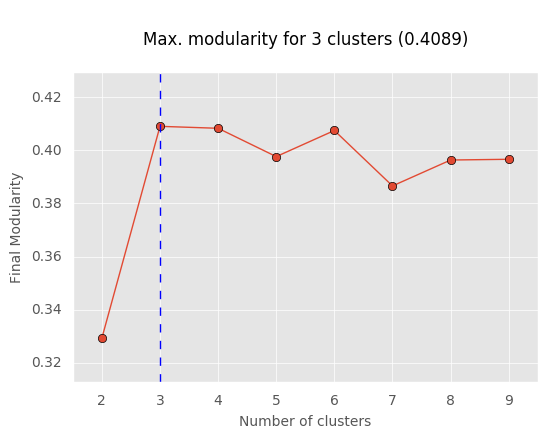

In [6]:
# ** Plot all final modularities **
plot_max_modularities(all_max_modularities, range_n_clusters)

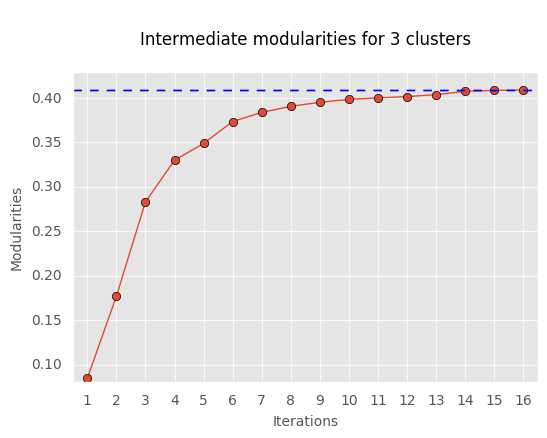

In [7]:
# ** Plot intermediate modularities for the best CoClust final modularity **
plot_intermediate_modularities(best_coclustMod_model)

Number of top terms: [default: 10] ''


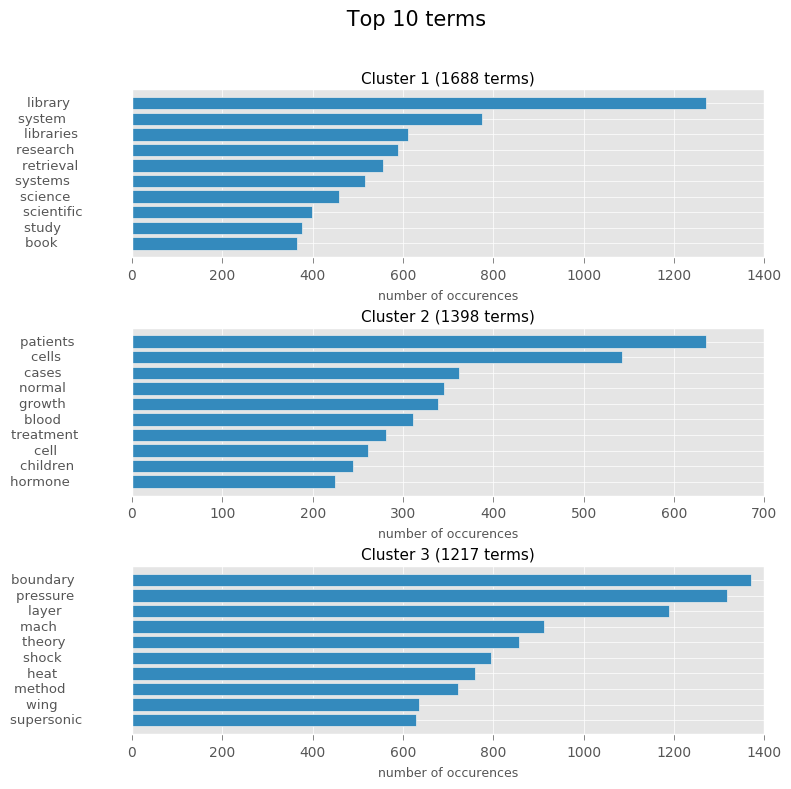

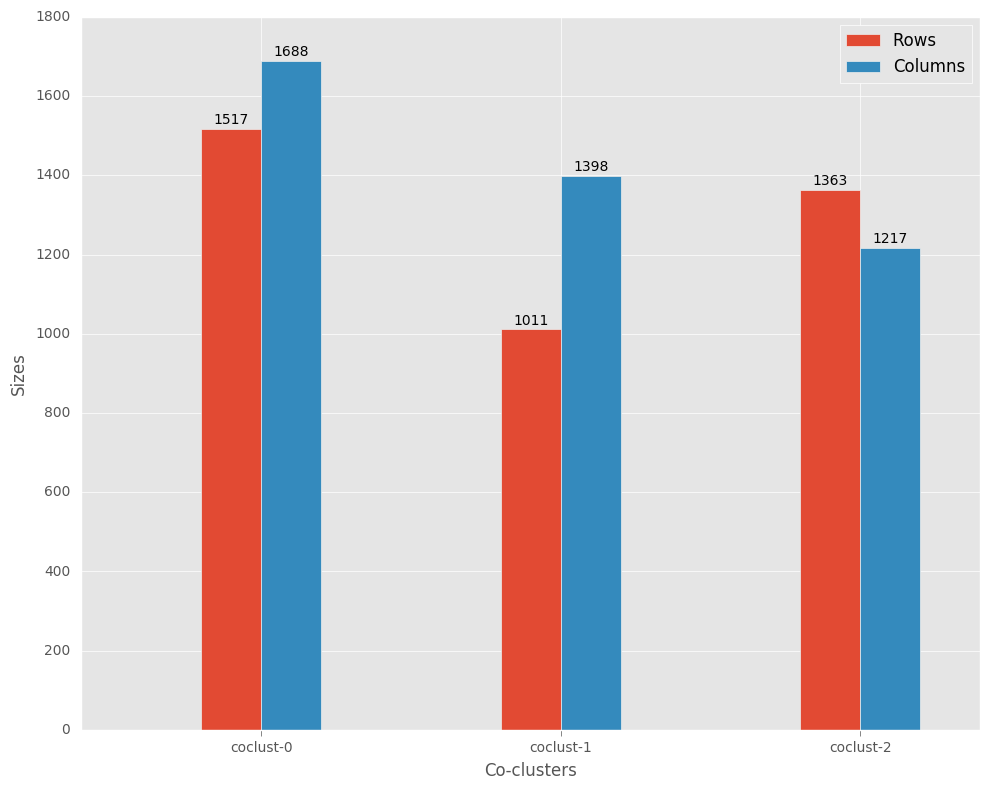

In [8]:
# ** Plot top terms for each cluster and the cluster sizes **
n_terms = input_with_default_int('Number of top terms', 10)

# --> top terms
plot_cluster_top_terms(doc_term_data['doc_term_matrix'], doc_term_data['term_labels'], n_terms, best_coclustMod_model)
# --> cluster sizes
plot_cluster_sizes(best_coclustMod_model)

In [9]:
# ** Plot the term graph for a given cluster of terms **
n_cluster = input_with_default_int('Number of cluster', 1)
n_top_terms = input_with_default_int('Number of top terms', 25)
n_neighbors = input_with_default_int('Number of neighbors', 10)

graph = get_term_graph(X = doc_term_data['doc_term_matrix'], model = best_coclustMod_model, 
                       terms = doc_term_data['term_labels'], n_cluster = n_cluster, 
                       n_top_terms = n_top_terms, n_neighbors = n_neighbors)

Number of cluster: [default: 1] ''
Number of top terms: [default: 25] ''
Number of neighbors: [default: 10] ''


In [10]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [11]:
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("""
           window.graph={};
           """.format(graph))

<IPython.core.display.Javascript object>

In [12]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  element.append("<div id='chart1'></div>");
  $("#chart1").width("1160px");
  $("#chart1").height("800px");        
  var margin = {top: 20, right: 20, bottom: 30, left: 40};
  var width = 1280 - margin.left - margin.right;
  var height = 800 - margin.top - margin.bottom;
  var svg = d3.select("#chart1").append("svg")
    .style("position", "relative")
    .style("max-width", "960px")
    .attr("width", width + "px")
    .attr("height", (height + 50) + "px")
    .call(d3.behavior.zoom().on("zoom", redraw))
    .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
  function redraw() {
      svg.attr("transform",
               "translate(" + d3.event.translate + ")"
               + " scale(" + d3.event.scale + ")");
  }   

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-500)
    //.linkDistance(5)
    .linkDistance(function(d) { return (1 - d.value); })
    .size([width, height]);

  var graph = window.graph;
    
  force
      .nodes(graph.nodes)
      .links(graph.links)
      .start();

  var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link")
      .style("stroke", "#999;")
      .style("stroke-opacity", .6)
      .style("stroke-width", function(d) { return Math.sqrt(d.value); })
  
      .style("stroke", "blue");

  var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("g")
      .attr("class", "node")
      .call(force.drag);
    
  node.append("circle")
      .attr("class", "node_circle")
      .attr("r", 8)
      .style("fill", function(d) { return color(d.group); });

  node.append("text")
      .attr("class", "node_text")
      .attr("dx", 12)
      .attr("dy", ".35em")
      .text(function(d) { return d.name });

  node.append("title")
      .text(function(d) { return d.name; });

  var node_text = svg.selectAll(".node_text");
  var node_circle = svg.selectAll(".node_circle");
    
  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node_circle.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
      
    node_text.attr("x", function(d) { return d.x; })
        .attr("y", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

In [13]:
# ** Compute spectral co-clustering with the CoclustSpecMod approach **

n_clusters = best_coclustMod_model.n_clusters
# Perform co-clustering
coclust_specMod_model = CoclustSpecMod(n_clusters=n_clusters, random_state=0)
coclust_specMod_model.fit(doc_term_data['doc_term_matrix'])

Number of top terms: [default: 10] ''


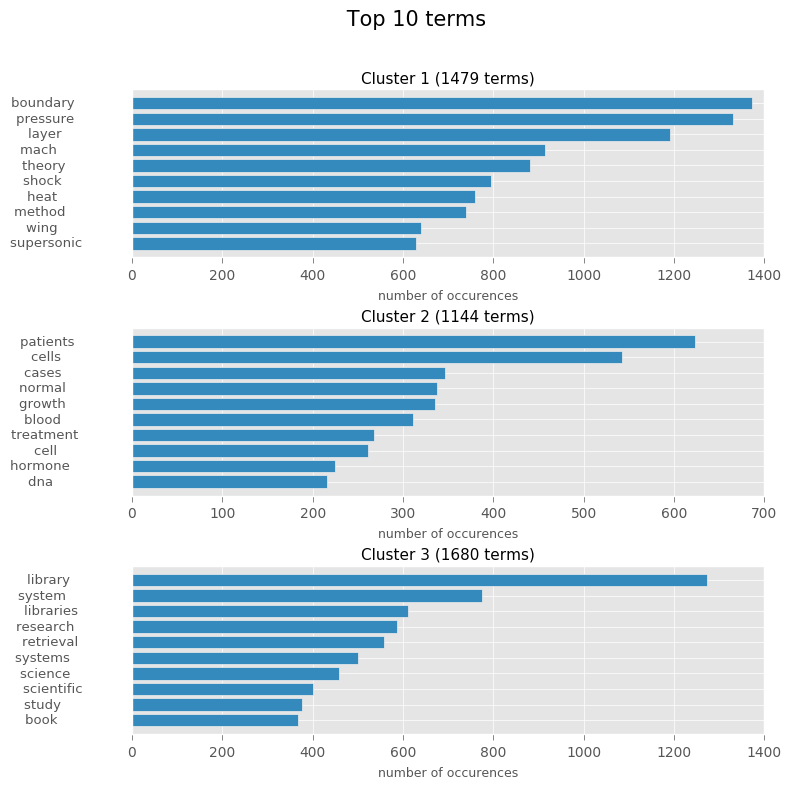

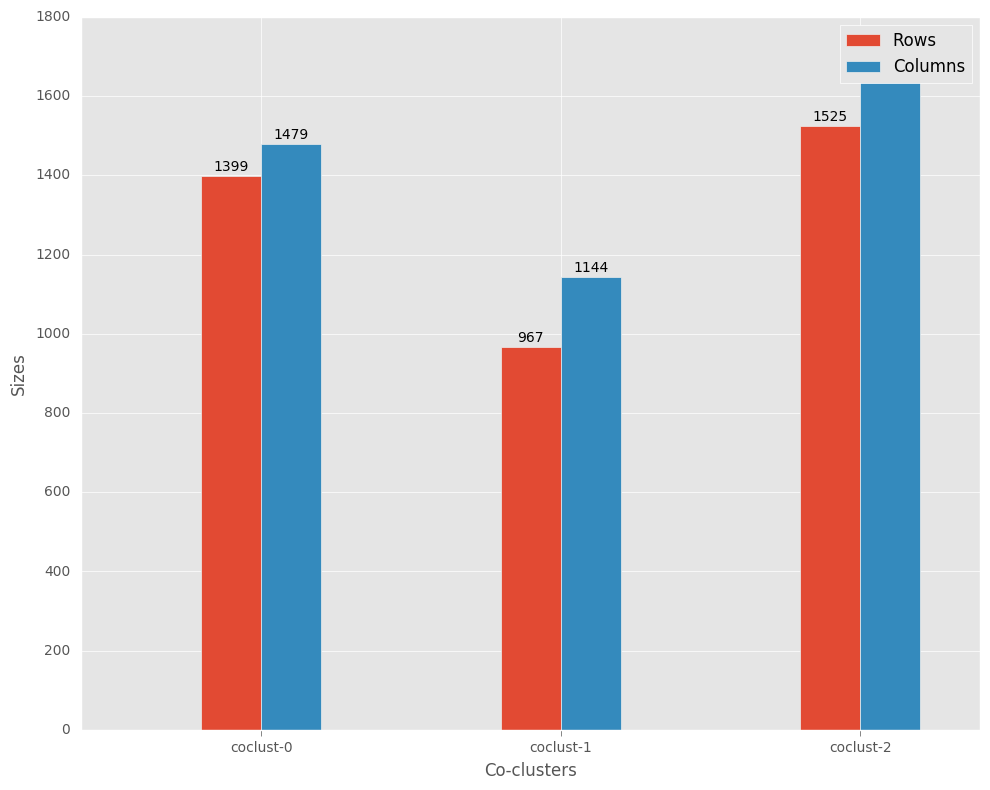

In [14]:
# ** Plot top terms for each cluster and the cluster sizes **

n_terms = input_with_default_int('Number of top terms', 10)

# --> top terms
plot_cluster_top_terms(doc_term_data['doc_term_matrix'], doc_term_data['term_labels'], n_terms, coclust_specMod_model)
# --> cluster sizes
plot_cluster_sizes(coclust_specMod_model)

In [15]:
# ** Compute co-clustering with the CoclustInfo approach **

n_clusters = best_coclustMod_model.n_clusters
n_rand_init = input_with_default_int('Number of random initialization', 1)
# Perform co-clustering
coclust_info_model = CoclustInfo(n_row_clusters = n_clusters, n_col_clusters = n_clusters,
                                 n_init = n_rand_init, random_state = 0)
coclust_info_model.fit(doc_term_data['doc_term_matrix'])

Number of random initialization: [default: 1] ''


In [16]:
# ** Compare clustering quality measure for coClustMod, coClustSpecMod and info **

true_row_labels = doc_term_data['doc_labels']
n_clusters = best_coclustMod_model.n_clusters

def print_NMI_and_ARI(true_row_labels, predicted_row_labels):
    nmi_ = nmi(true_row_labels, predicted_row_labels)
    ari_ = ari(true_row_labels, predicted_row_labels)
    print("NMI: {}\nARI: {}".format(nmi_, ari_))

## Evaluate the results for (Best) Modularity co-clustering
print(10*'=')
print("(Best) Modularity co-clustering")
print(5*'-')
#print("CRITERION: %s" % best_coclustMod_model.criterion)
predicted_row_labels = best_coclustMod_model.row_labels_
print_NMI_and_ARI(true_row_labels, predicted_row_labels)
print_accuracy = accuracy(doc_term_data['doc_term_matrix'], n_clusters, true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)
            
## Evaluate the results for Spectral Modularity co-clustering
print(10*'=')
print("Spectral Modularity co-clustering")
print(5*'-')
#print("CRITERION: %s" % coclust_specMod_model.criterion)
predicted_row_labels = coclust_specMod_model.row_labels_
print_NMI_and_ARI(true_row_labels, predicted_row_labels)
print_accuracy = accuracy(doc_term_data['doc_term_matrix'], n_clusters, true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)
      
## Evaluate the results for Info co-clustering
print(10*'=')
print("Info co-clustering")
print(5*'-')
print("CRITERION: %s" % coclust_info_model.criterion)
predicted_row_labels = coclust_info_model.row_labels_
print_NMI_and_ARI(true_row_labels, predicted_row_labels)
print_accuracy = accuracy(doc_term_data['doc_term_matrix'], n_clusters, true_row_labels, predicted_row_labels)
print("ACCURACY: %s" % print_accuracy)

(Best) Modularity co-clustering
-----
NMI: 0.902094144579
ARI: 0.937922418426
ACCURACY: 0.978925726034
Spectral Modularity co-clustering
-----
NMI: 0.913719371893
ARI: 0.941247834466
ACCURACY: 0.979439732717
Info co-clustering
-----
CRITERION: 0.368259482727
NMI: 0.930673152976
ARI: 0.959306989875
ACCURACY: 0.986378822925
